In [1]:
import xarray as xr
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using:',device)

We are using: cuda


### READ netCDF dataset

In [3]:
#Xarray reads the NETCDF lazily. Only when an operation is needed the values are loaded.
ds_kappa_psi=xr.open_dataset('kappa_psi_dataset.nc')
print(ds_kappa_psi)

<xarray.Dataset> Size: 4GB
Dimensions:  (times: 241734, z: 65, r: 65, shot: 1050)
Coordinates:
  * times    (times) float32 967kB 100.0 180.0 200.0 ... 5.266e+06 5.266e+06
  * shot     (shot) int32 4kB 160016 160067 160072 ... 194915 194959 194993
  * z        (z) float32 260B -1.6 -1.55 -1.5 -1.45 -1.4 ... 1.45 1.5 1.55 1.6
  * r        (r) float32 260B 0.84 0.8666 0.8931 0.9197 ... 2.487 2.513 2.54
Data variables:
    psirz    (times, z, r) float32 4GB ...
    kappa    (times) float32 967kB ...


## Reducing the imbalance in the dataset

Text(0.5, 1.0, 'Histogram')

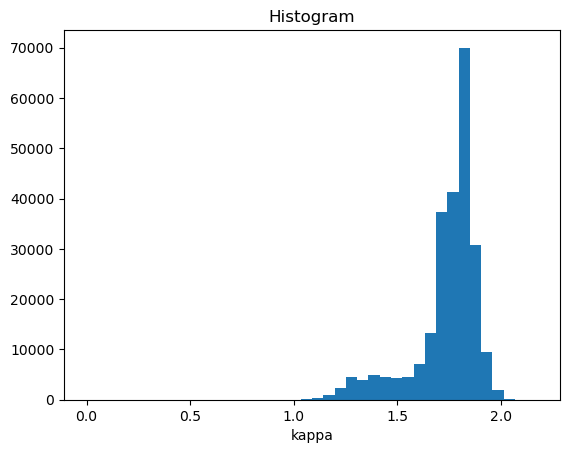

In [4]:
ds_kappa_psi['kappa'].plot.hist(bins=40)
plt.xlabel('kappa')
plt.title('Histogram')

We wnt to remove 80% of the points where 1.6<kappa<1.9

In [5]:
ratio=0.15
#a list of time values where kappa is between certain values
list_kappa_values =ds_kappa_psi['times'][(ds_kappa_psi['kappa']>1.65) & (ds_kappa_psi['kappa']<1.9)].values
print('list length:',len(list_kappa_values))
#reduce the list by 'ratio' (thos will be the ones we will keep)
num_to_remove=int(ratio*len(list_kappa_values))
indices_to_remove = np.random.choice(len(list_kappa_values), num_to_remove, replace=False)
list_kappa_values=np.delete(list_kappa_values,indices_to_remove)
print(len(list_kappa_values))

list length: 187865
159686


In [6]:
ds_small = ds_kappa_psi.drop_sel(times=list_kappa_values)

In [7]:
ds_small

<xarray.Dataset> Size: 1GB
Dimensions:  (times: 82048, z: 65, r: 65, shot: 1050)
Coordinates:
  * times    (times) float32 328kB 100.0 360.0 460.0 ... 5.266e+06 5.266e+06
  * shot     (shot) int32 4kB 160016 160067 160072 ... 194915 194959 194993
  * z        (z) float32 260B -1.6 -1.55 -1.5 -1.45 -1.4 ... 1.45 1.5 1.55 1.6
  * r        (r) float32 260B 0.84 0.8666 0.8931 0.9197 ... 2.487 2.513 2.54
Data variables:
    psirz    (times, z, r) float32 1GB ...
    kappa    (times) float32 328kB 1.418 1.867 1.864 1.876 ... 1.285 1.256 1.233

(array([3.5000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        4.0000e+00, 2.0000e+00, 6.0000e+00, 6.0000e+00, 1.0300e+02,
        5.3100e+02, 2.1390e+03, 5.3390e+03, 5.7110e+03, 6.2190e+03,
        5.5370e+03, 6.6620e+03, 8.7040e+03, 6.3770e+03, 9.7460e+03,
        1.0534e+04, 1.2197e+04, 2.0580e+03, 1.3200e+02, 4.0000e+00]),
 array([0.        , 0.07261186, 0.14522372, 0.21783558, 0.29044744,
        0.36305931, 0.43567115, 0.50828302, 0.58089489, 0.65350676,
        0.72611862, 0.79873049, 0.8713423 , 0.94395417, 1.01656604,
        1.08917797, 1.16178977, 1.23440158, 1.30701351, 1.37962532,
        1.45223725, 1.52484906, 1.59746099, 1.67007279, 1.7426846 ,
        1.81529653, 1.88790834, 1.96052027, 2.03313208, 2.10574389,
        2.17835593]),
 <BarContainer object of 30 artists>)

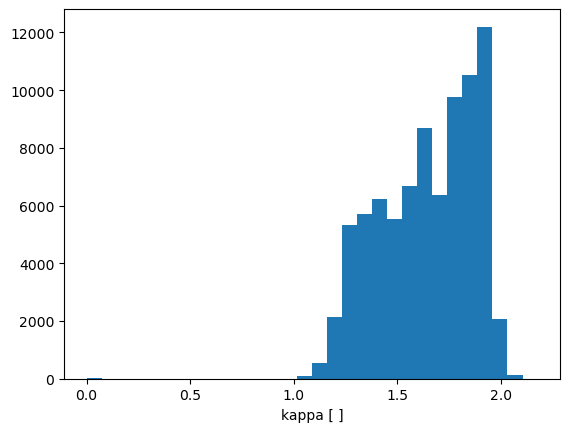

In [8]:
ds_small['kappa'].plot.hist(bins=30)

### USe a small batch of the dataset

In [9]:
#REducing the Dataset size for less memory operations
##ds_small=ds_kappa_psi.isel(times=slice(0,10000))

### Define the Variables in our model

In [10]:
y=ds_small['kappa'].values
x=ds_small['psirz'].values

In [11]:
np.shape(x)

(82048, 65, 65)

In [12]:
# Normalize each 2D array to range [0, 1] using its own min/max
def normalize_to_range(tensor):
    """
    Normalize each 2D array to range [0, 1] using its own min/max
    tensor shape: (N, H, W) where N is number of samples
    """
    normalized_list = []
    for i in range(tensor.size(0)):
        array_2d = tensor[i]
        max_val = array_2d.max()
        min_val = array_2d.min()
        range_val = max_val - min_val
        normalized_array = (array_2d - min_val) / range_val
        normalized_list.append(normalized_array)
    
    return torch.stack(normalized_list)

In [13]:
y_tensor=torch.tensor(y)
x_tensor=torch.tensor(x)
x_tensor = torch.unsqueeze(x_tensor,1) #add channdel dimension (to be consistent with Pytorch standard)
print(x_tensor.shape)

#normalize x
#x_mean = x_tensor.mean()
#x_std = x_tensor.std()
#x_tensor_normalized = (x_tensor - x_mean) / x_std
x_tensor_normalized = normalize_to_range(x_tensor)

#normalize y
y_mean = y_tensor.mean()
y_std = y_tensor.std()
y_tensor_normalized = (y_tensor - y_mean) / y_std

dataset=TensorDataset(x_tensor_normalized,y_tensor_normalized)

torch.Size([82048, 1, 65, 65])


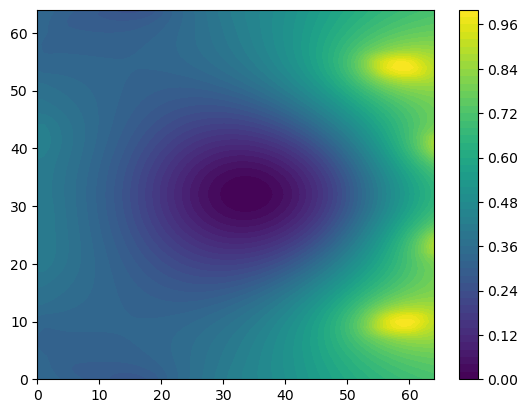

In [14]:
rand_index=300
image_test=x_tensor_normalized[rand_index][0].numpy()
plt.contourf(image_test,levels=50)
plt.colorbar()

## Splitting the dataset (training and testing)

In [15]:
#split in to train(70%) and test(30%) datasets
train_dataset, test_dataset = random_split(dataset,[0.7,0.3])

In [16]:
batch_size=64
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,pin_memory=True,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size,pin_memory=True)

In [17]:
#calculate the number of 'steps' in the training(testing) loop for future calculations
train_steps=len(train_dataloader.dataset)//batch_size
test_steps=len(test_dataloader.dataset)//batch_size

### Define the model

In [33]:
class smallCNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=5,kernel_size=5,stride=2,padding=1)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=3,stride=2)
        self.conv2=nn.Conv2d(in_channels=5,out_channels=15,kernel_size=5,stride=2,padding=0)
        self.relu2=nn.ReLU()
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=1)
        self.fc1=nn.Linear(375,100)
        self.relu3=nn.ReLU()
        self.drop1=nn.Dropout(0.2)
        self.fc2=nn.Linear(100,30)
        self.relu4=nn.ReLU()
        self.drop2=nn.Dropout(0.2)
        self.fc3=nn.Linear(30,1)

    def forward(self,x):
        #input batch*1*65*65  output batch*5*31*31
        x=self.conv1(x)
        x=self.relu1(x)
        #input batch*5*31*31 output batch*5*15*15
        x=self.pool1(x)
        #input batch*5*15*15 output batch*15*6*6
        x=self.conv2(x)
        x=self.relu2(x)
        #input batch*15*6*6 output batch*15*5*5
        x=self.pool2(x)
        
        x=torch.flatten(x,1)
        x=self.fc1(x)
        x=self.relu3(x)
        x=self.drop1(x)
        x=self.fc2(x)
        x=self.relu4(x)
        x=self.drop2(x)
        x=self.fc3(x)
        return x
    

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #first conv block
        self.conv1=nn.Conv2d(in_channels=1,out_channels=10,kernel_size=8,stride=1,padding=0)
        self.bn1=nn.BatchNorm2d(10)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2,stride=2)

        #second conv block
        self.conv2=nn.Conv2d(in_channels=10,out_channels=30,kernel_size=5,stride=1,padding=0)
        self.bn2=nn.BatchNorm2d(30)
        self.relu2=nn.ReLU()
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)

        #third conv block
        self.conv3=nn.Conv2d(in_channels=30,out_channels=50,kernel_size=4,stride=1,padding=0)
        self.bn3=nn.BatchNorm2d(50)
        self.relu3=nn.ReLU()
        self.pool3=nn.MaxPool2d(kernel_size=3,stride=2)

        #fully connected layers
        self.fc1=nn.Linear(800,256)
        self.bn4=nn.BatchNorm1d(256)
        self.relu4=nn.ReLU()
        self.drop1=nn.Dropout(0.2)

        self.fc2=nn.Linear(256,64)
        self.relu5=nn.ReLU()
        self.drop2=nn.Dropout(0.2)

        self.fc3=nn.Linear(64,1)

    def forward(self,x):
        #input batch*1*65*65  output batch*10*58*58
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu1(x)
        #input batch*10*58*58 output batch*10*28*28
        x=self.pool1(x)

        #input batch*10*28*28 output batch*30*24*24
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu2(x)
        #input batch*30*24*24 output batch*30*12*12
        x=self.pool2(x)

        #input batch*30*12*12 output batch*50*9*9
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.relu3(x)
        #input batch*50*9*9 output batch*50*4*4
        x=self.pool3(x)
        
        x=torch.flatten(x,1)
        x=self.fc1(x)
        x=self.bn4(x)
        x=self.relu4(x)
        x=self.drop1(x)

        x=self.fc2(x)
        x=self.relu5(x)
        x=self.drop2(x)

        x=self.fc3(x)
        return x
    

In [47]:
#hyperparameters
learning_rate=0.001
epochs=30
#weight_decay = 1e-4  # L2 regularization

In [48]:
%%time
model=CNN()
model.to(device)
optim=torch.optim.Adam(model.parameters(),lr=learning_rate)
#optim=torch.optim.AdamW(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
loss_fn=nn.MSELoss()
#loss_fn=nn.L1Loss()
train_loss_list=[]
test_loss_list=[]
for e in range(epochs):
    #train
    model.train()
    train_loss=0
    for fluxsurf,kappa in train_dataloader:
        fluxsurf = fluxsurf.to(device)
        kappa = kappa.to(device)
        predict = model(fluxsurf)
        loss=loss_fn(predict,kappa)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+=loss.item()
    train_loss=train_loss/train_steps #average loss in the train loop
    
    #test
    test_loss=0
    with torch.no_grad():
        model.eval()
        for fluxsurf,kappa in test_dataloader:
            fluxsurf = fluxsurf.to(device)
            kappa = kappa.to(device)
            predict=model(fluxsurf)
            loss=loss_fn(predict,kappa)
            test_loss+=loss.item()
    test_loss=test_loss/test_steps
            
    print('Current epoch:{},  training loss:{:.4f},  test loss{:.4f}'.format(e+1,train_loss,test_loss))
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

Current epoch:1,  training loss:1.0059,  test loss0.9967
Current epoch:2,  training loss:1.0041,  test loss0.9962
Current epoch:3,  training loss:1.0034,  test loss0.9965
Current epoch:4,  training loss:1.0021,  test loss0.9964
Current epoch:5,  training loss:1.0012,  test loss1.0005
Current epoch:6,  training loss:0.9992,  test loss1.0010
Current epoch:7,  training loss:0.9977,  test loss1.0023
Current epoch:8,  training loss:0.9977,  test loss0.9983
Current epoch:9,  training loss:0.9971,  test loss1.0017
Current epoch:10,  training loss:0.9973,  test loss1.0021
Current epoch:11,  training loss:0.9969,  test loss0.9982
Current epoch:12,  training loss:0.9966,  test loss0.9968
Current epoch:13,  training loss:0.9953,  test loss0.9974
Current epoch:14,  training loss:0.9954,  test loss0.9982
Current epoch:15,  training loss:0.9949,  test loss0.9981
Current epoch:16,  training loss:0.9968,  test loss1.0015
Current epoch:17,  training loss:0.9950,  test loss1.0016
Current epoch:18,  trai

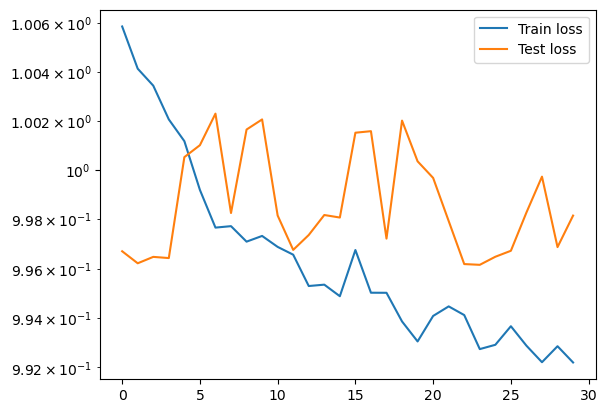

In [49]:
plt.plot(train_loss_list,label='Train loss')
plt.plot(test_loss_list,label='Test loss')
plt.yscale('log')
plt.legend()

### Analyze model error

In [51]:
real_kappa_list=[]
predict_kappa_list=[]
with torch.no_grad():
    model.eval()
    for fluxsurf,kappa in test_dataloader:
        fluxsurf = fluxsurf.to(device)
        kappa = kappa.to(device)
        predict=model(fluxsurf)
        #loss=loss_fn(predict,kappa)
        predict=torch.squeeze(predict,1)
        real_kappa_list.extend(kappa.cpu().tolist())
        predict_kappa_list.extend(predict.cpu().tolist())
real_kappa=np.array(real_kappa_list)
predict_kappa=np.array(predict_kappa_list)

[-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
  0.66666667  1.11111111  1.55555556  2.        ]


Text(0.5, 1.0, 'Prediction vs Real Kappa (normalized)')

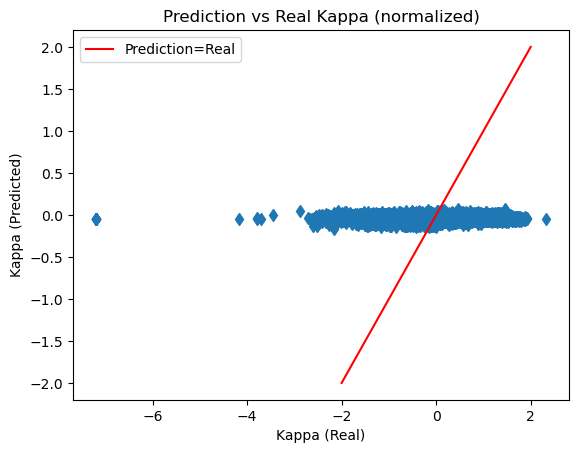

In [52]:
plt.plot(real_kappa,predict_kappa,linestyle='None',marker='d')
aux_kappa_real=np.linspace(-2,2,10) #np.linspace(1.6,1.9,10)
aux_kappa_predict=np.linspace(-2,2,10) #np.linspace(1.6,1.9,10)
print(aux_kappa_predict)
plt.plot(aux_kappa_real,aux_kappa_predict,linestyle='-',color='r',label='Prediction=Real')
plt.xlabel('Kappa (Real)')
plt.ylabel('Kappa (Predicted)')
plt.legend()
plt.title('Prediction vs Real Kappa (normalized)')

In [53]:
#mean absolute error
mae=np.abs(real_kappa-predict_kappa)

Text(0, 0.5, 'MAE')

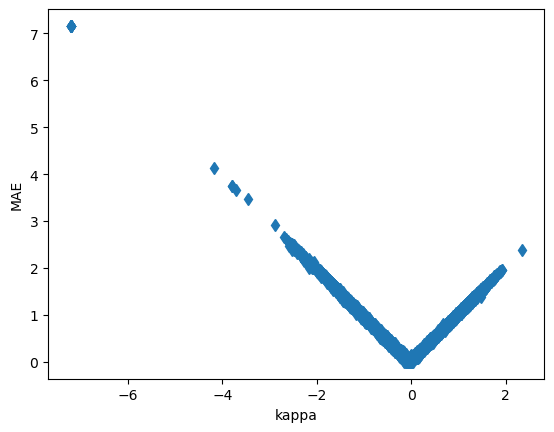

In [54]:
plt.plot(real_kappa,mae,linestyle='None',marker='d')
plt.xlabel('kappa')
plt.ylabel('MAE')

Text(0.5, 0, 'MAE')

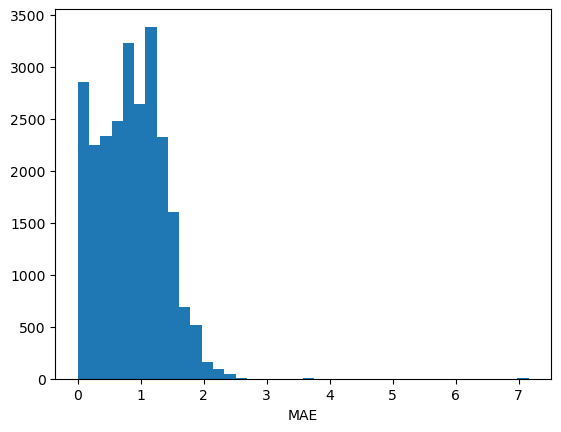

In [55]:
plt.hist(mae,bins=40)
plt.xlabel('MAE')

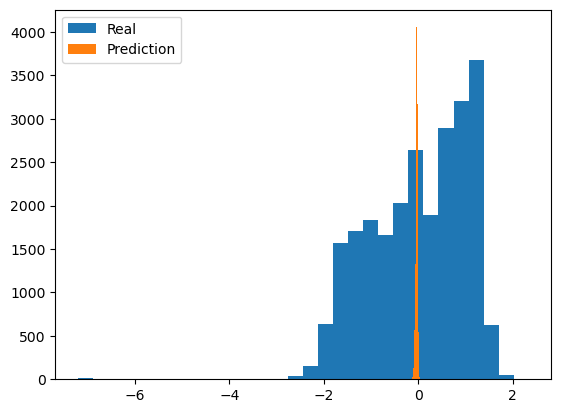

In [56]:
plt.hist(real_kappa,bins=30,label='Real')
plt.hist(predict_kappa,bins=30,label='Prediction')
plt.legend()

In [57]:
real_kappa.mean()

np.float64(0.00620948993844386)

In [58]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 254491
